<a href="https://colab.research.google.com/github/RedEye1605/9-Rhendy-Japelhendal-Saragih-Sumbayak/blob/main/Intern_DS_2025_ML_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from typing import Callable, Tuple, List, Union, Optional
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs, make_moons, make_circles

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

from IPython.display import display, clear_output

# Functions

In [ ]:
def generate_regression_data(
    n_samples: int = 500,
    n_features: int = 1,
    coefficients: Union[list, np.ndarray] = [3],
    intercept: float = 4,
    noise_std: float = 1.0,
    feature_dist: str = "uniform",
    feature_params: dict = {"low": 0, "high": 10},
    non_linearity: Callable[[np.ndarray], np.ndarray] = None,
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Generates sample data for regression (linear or non-linear).

    Args:
        n_samples: The number of samples to generate.
        n_features: The number of features.
        coefficients: Coefficients for each feature (linear component).  Must have
            length `n_features`.  If a list is provided, it will be converted
            to a NumPy array.
        intercept: The intercept term (linear component).
        noise_std: Standard deviation of the Gaussian noise added to the target.
        feature_dist: Distribution of the features.  Supported options:
            - "uniform": Uniform distribution.  `feature_params` should contain
              "low" and "high" keys.
            - "normal":  Normal (Gaussian) distribution.  `feature_params`
              should contain "loc" (mean) and "scale" (standard deviation) keys.
            - "exponential": Exponential distribution. `feature_params`
              should contain the "scale" key (which is 1/lambda).
        feature_params: Parameters for the specified `feature_dist`.  See the
            descriptions for `feature_dist` for details.
        non_linearity:  An optional callable (function) that takes the linear
            combination of features and coefficients as input and returns a
            transformed value.  This introduces non-linearity.
        seed: The random seed to use.

    Returns:
        A tuple containing the feature matrix (X) and the target variable (y).
        X has shape (n_samples, n_features), and y has shape (n_samples, 1).

    Raises:
        ValueError: If the length of `coefficients` does not match `n_features`.
        ValueError: If an unsupported `feature_dist` is specified.
        ValueError: If required parameters for `feature_dist` are missing.
    """

    np.random.seed(seed)

    if len(coefficients) != n_features:
        raise ValueError(
            "The length of coefficients must match the number of features."
        )
    coefficients = np.array(coefficients).reshape(n_features, 1)  # Ensure correct shape

    # Generate features based on the specified distribution
    if feature_dist == "uniform":
        if "low" not in feature_params or "high" not in feature_params:
            raise ValueError(
                "feature_params must contain 'low' and 'high' for uniform distribution."
            )
        X = np.random.uniform(
            feature_params["low"], feature_params["high"], size=(n_samples, n_features)
        )
    elif feature_dist == "normal":
        if "loc" not in feature_params or "scale" not in feature_params:
            raise ValueError(
                "feature_params must contain 'loc' and 'scale' for normal distribution."
            )
        X = np.random.normal(
            feature_params["loc"],
            feature_params["scale"],
            size=(n_samples, n_features),
        )
    elif feature_dist == "exponential":
        if "scale" not in feature_params:
            raise ValueError(
                "feature_params must contain 'scale' for exponential distribution."
            )
        X = np.random.exponential(
            feature_params["scale"], size=(n_samples, n_features)
        )
    else:
        raise ValueError(f"Unsupported feature distribution: {feature_dist}")

    # Calculate the linear component
    linear_component = X @ coefficients + intercept

    # Apply non-linearity if provided
    if non_linearity:
        linear_component = non_linearity(linear_component)

    # Add noise
    y = linear_component + np.random.normal(0, noise_std, size=(n_samples, 1))

    return X, y

In [ ]:
def generate_classification_data(
    n_samples: int = 500,
    n_features: int = 2,
    n_classes: int = 2,
    class_sep: float = 1.0,
    cluster_std: Union[float, List[float]] = 1.0,
    data_type: str = "blobs",
    data_params: dict = {},
    decision_boundary: Callable[[np.ndarray], np.ndarray] = None,
    noise_std: float = 0.0,
    random_state: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Generates sample data for classification (linear or non-linear).

    Args:
        n_samples: The number of samples to generate.
        n_features: The number of features.
        n_classes: The number of classes.
        class_sep:  The factor multiplying the hypercube dimension.  Larger
            values spread out the clusters/classes.  Only used for 'blobs'.
        cluster_std:  The standard deviation of the clusters. Can be a single
            float (applied to all clusters) or a list of floats (one for each
            cluster). Only used for 'blobs'.
        data_type: The type of data to generate.  Supported options:
            - "blobs":  Generate isotropic Gaussian blobs (clusters).
            - "moons":  Generate two interleaving half circles.
            - "circles": Generate a large circle containing a smaller circle.
            - "custom": Use a custom decision boundary function.
        data_params:  Additional parameters specific to the `data_type`.
            - "moons":  `noise` (standard deviation of Gaussian noise added).
            - "circles": `noise` (standard deviation of Gaussian noise),
                        `factor` (scale factor between inner and outer circle, 0 < factor < 1).
        decision_boundary:  A callable (function) that takes the feature matrix
            (X) as input and returns a 1D array of class labels (0, 1, ...).
            Only used for `data_type="custom"`. This defines the custom
            decision boundary.
        noise_std: Standard deviation of Gaussian noise added to *feature values*.
            This is applied *after* generating the data and determining
            the classes, effectively "blurring" the data points.
        random_state: The random seed to use.

    Returns:
        A tuple containing the feature matrix (X) and the target variable (y).
        X has shape (n_samples, n_features), and y has shape (n_samples,).

    Raises:
        ValueError: If an unsupported `data_type` is specified.
        ValueError: If `decision_boundary` is not provided for `data_type="custom"`.
    """

    if data_type == "blobs":
        X, y = make_blobs(
            n_samples=n_samples,
            n_features=n_features,
            centers=n_classes,
            cluster_std=cluster_std,
            center_box=(-10.0, 10.0),  # Control the range of cluster centers
            shuffle=True,
            random_state=random_state,
            return_centers=False, # We only need X and y
        )
    elif data_type == "moons":
        X, y = make_moons(
            n_samples=n_samples,
            shuffle=True,
            noise=data_params.get("noise", 0.05),  # Default noise for moons
            random_state=random_state,
        )
    elif data_type == "circles":
        X, y = make_circles(
            n_samples=n_samples,
            shuffle=True,
            noise=data_params.get("noise", 0.05),  # Default noise for circles
            random_state=random_state,
            factor=data_params.get("factor", 0.8),  # Default factor for circles
        )
    elif data_type == "custom":
        if decision_boundary is None:
            raise ValueError(
                "decision_boundary must be provided for data_type='custom'."
            )
        # Generate features uniformly (you can customize this as in the regression example)
        X = np.random.uniform(-10, 10, size=(n_samples, n_features))
        y = decision_boundary(X)  # Apply the custom decision boundary

    else:
        raise ValueError(f"Unsupported data type: {data_type}")

    # Add feature noise
    if noise_std > 0:
        rng = np.random.RandomState(random_state)  # Use a separate RandomState for noise
        X += rng.normal(0, noise_std, size=X.shape)

    return X, y.astype(int)  # Ensure y is integer type

In [ ]:
def train_and_visualize_regression_iteratively(
    regressor,
    X: np.ndarray,
    y: np.ndarray,
    n_iterations: int = 100,
    batch_size: Optional[int] = None,
    learning_rate: str = "constant",
    eta0: float = 0.01,
    plot_every: int = 10,
    filename_prefix: str = "regression_iter",
    random_state: Optional[int] = None,
    degree: Optional[int] = None,
):
    """Trains a regression model iteratively and visualizes the curve fitting using coefficients."""

    if batch_size is None:
        if not hasattr(regressor, "fit"):
            raise TypeError("If batch_size is None, regressor must support 'fit'.")
    elif batch_size <= 0:
        raise ValueError("batch_size must be positive or None")

    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]

    if degree is not None:
        pipeline_steps = [
            ("poly", PolynomialFeatures(degree=degree)),
            ("scaler", StandardScaler()),
            ("regressor", regressor),
        ]
        model = Pipeline(pipeline_steps)
    else:
        pipeline_steps = [("scaler", StandardScaler()), ("regressor", regressor)]
        model = Pipeline(pipeline_steps)

    supports_lr_args = (
        "learning_rate" in model.named_steps["regressor"].get_params()
        and "eta0" in model.named_steps["regressor"].get_params()
    )

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X, y, label="Actual Data", alpha=0.7)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_title("Iterative Regression Curve Fitting")
    ax.grid(True)
    ax.legend()
    y = y.ravel()

    # Prepare X for plotting (using linspace for a smooth curve)
    X_plot = np.linspace(X.min(), X.max(), 5000).reshape(-1, 1)

    for iteration in range(1, n_iterations + 1):
        if batch_size is None:
            model.fit(X, y)
        else:
            indices = rng.permutation(n_samples)
            for i in range(0, n_samples, batch_size):
                batch_indices = indices[i : min(i + batch_size, n_samples)]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                if degree is not None:
                    X_batch_transformed = model.named_steps["poly"].fit_transform(
                        X_batch
                    )
                    X_batch_transformed = model.named_steps["scaler"].fit_transform(
                        X_batch_transformed
                    )
                else:
                    X_batch_transformed = model.named_steps["scaler"].fit_transform(
                        X_batch
                    )

                if supports_lr_args:
                    model.named_steps["regressor"].partial_fit(
                        X_batch_transformed, y_batch
                    )
                else:
                    model.named_steps["regressor"].partial_fit(
                        X_batch_transformed, y_batch
                    )

        if iteration % plot_every == 0 or iteration == 1:
            # --- Calculate y_pred using coefficients ---
            regressor_ = model.named_steps["regressor"]
            if hasattr(regressor_, "coef_") and hasattr(regressor_, "intercept_"):

                if degree is not None:
                    # Transform X_plot for polynomial features
                    X_plot_transformed = model.named_steps["poly"].transform(X_plot)
                    X_plot_transformed = model.named_steps["scaler"].transform(X_plot_transformed)
                    y_pred = X_plot_transformed @ regressor_.coef_.T + regressor_.intercept_

                else:
                    # Transform for linear regression
                    X_plot_transformed = model.named_steps["scaler"].transform(X_plot)
                    y_pred = X_plot_transformed @ regressor_.coef_.T + regressor_.intercept_
                    if y_pred.ndim > 1 and y_pred.shape[1] == 1:
                        y_pred = y_pred.ravel()  # Ensure y_pred is 1D


            else:
                # Fallback to predict if coef_ and intercept_ are not available
                y_pred = model.predict(X_plot)

            ax.cla()
            ax.scatter(X, y, label="Actual Data", alpha=0.7)
            ax.plot(
                X_plot, y_pred, color="red", alpha=0.8, label=f"Iteration {iteration}"
            )
            ax.set_xlabel("X")
            ax.set_ylabel("y")
            ax.set_title("Iterative Regression Curve Fitting")
            ax.grid(True)
            ax.legend()

            # --- Update the display ---
            clear_output(wait=True)  # Clear the previous output
            display(fig)  # Display the updated figure
            plt.pause(0.1)
            fig.canvas.draw_idle()  # Ensure the figure gets redrawn.
            plt.savefig(f"{filename_prefix}_{iteration:04d}.png")

    plt.close(fig)  # Close plot at the end.

In [ ]:
def train_and_visualize_classification_iteratively(
    classifier,
    X: np.ndarray,
    y: np.ndarray,
    n_iterations: int = 100,
    batch_size: Optional[int] = None,
    learning_rate: str = "constant",
    eta0: float = 0.01,
    plot_every: int = 10,
    filename_prefix: str = "classification_iter",
    random_state: Optional[int] = None,
    degree: Optional[int] = None,
):
    """Trains a classification model iteratively and visualizes the decision boundary."""

    if batch_size is None:
        if not hasattr(classifier, "fit"):
            raise TypeError("If batch_size is None, classifier must support 'fit'.")
    elif batch_size <= 0:
        raise ValueError("batch_size must be positive or None")

    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]

    if degree is not None:
        pipeline_steps = [
            ("poly", PolynomialFeatures(degree=degree)),
            ("scaler", StandardScaler()),
            ("classifier", classifier),
        ]
        model = Pipeline(pipeline_steps)
    else:
        pipeline_steps = [("scaler", StandardScaler()), ("classifier", classifier)]
        model = Pipeline(pipeline_steps)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolors="k")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_title("Iterative Classification Decision Boundary")

    # Create meshgrid for plotting decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    for iteration in range(1, n_iterations + 1):
        if batch_size is None:
            model.fit(X, y)
        else:
            indices = rng.permutation(n_samples)
            for i in range(0, n_samples, batch_size):
                batch_indices = indices[i : min(i + batch_size, n_samples)]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                if degree is not None:
                    X_batch_transformed = model.named_steps["poly"].fit_transform(
                        X_batch
                    )
                    X_batch_transformed = model.named_steps["scaler"].fit_transform(
                        X_batch_transformed
                    )
                else:
                    X_batch_transformed = model.named_steps["scaler"].fit_transform(
                        X_batch
                    )
                if iteration == 1:
                    # Pass classes parameter in the first call to partial_fit
                    model.named_steps["classifier"].partial_fit(
                        X_batch_transformed, y_batch, classes=np.unique(y)
                    )
                else:
                    model.named_steps["classifier"].partial_fit(
                        X_batch_transformed, y_batch
                    )

        if iteration % plot_every == 0 or iteration == 1:
            # Clear previous contours before plotting the new one
            for coll in ax.collections:  # crucial for removing previous contours
                if hasattr(coll, 'remove'): #for some reason, ax.collections contains collections and PathCollection
                  coll.remove()
            for c in ax.containers:
                ax.containers.remove(c)

            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, alpha=0.4, cmap="viridis")
            # Re-plot the scatter plot to keep the points on top of the contour
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolors="k") #keep scatter up-to-date
            ax.set_title(f"Iteration {iteration}")

            clear_output(wait=True)
            display(fig)
            plt.pause(0.1)
            fig.canvas.draw_idle()
            plt.savefig(f"{filename_prefix}_{iteration:04d}.png")

    plt.close(fig)

In [ ]:
def visualize_data(X, y):
  """Visualizes the data points in a scatter plot.

  Args:
    X: The feature data (numpy array).
    y: The target variable (numpy array).
  """
  plt.figure(figsize=(8, 6))
  plt.scatter(X, y, alpha=0.5)
  plt.xlabel("Feature (X)")
  plt.ylabel("Target Variable (y)")
  plt.title("Scatter Plot of Data Points")
  plt.grid(True)
  plt.show()

In [ ]:
def visualize_classification_data(X, y):
    """Visualizes 2D classification data.

    Args:
        X: A NumPy array of shape (n_samples, 2) representing the feature data.
        y: A NumPy array of shape (n_samples,) representing the class labels.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Classification Data Visualization")
    plt.grid(True)
    plt.show()

In [ ]:
def fn_one(x):
    return np.where(x < 0, 0, x**0.5)

# Regresi

## Linear data

In [ ]:
X, y = generate_regression_data(n_samples=250, n_features=1, coefficients=[1], intercept=0, noise_std=3, feature_params={'low':-10, 'high':10})

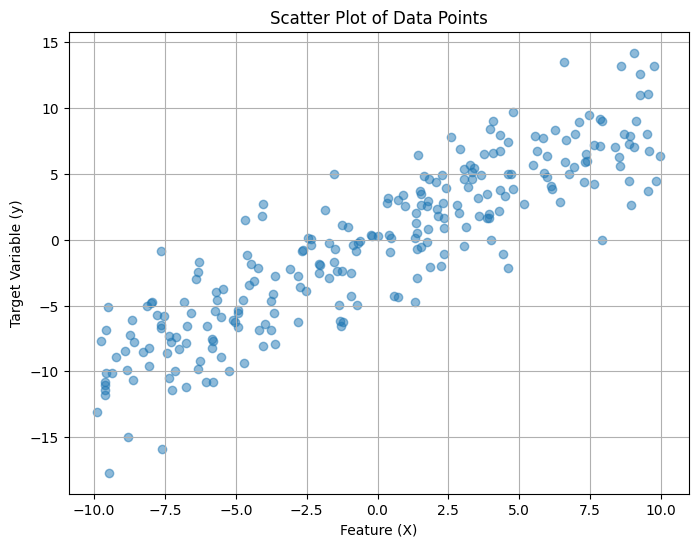

In [ ]:
visualize_data(X, y)

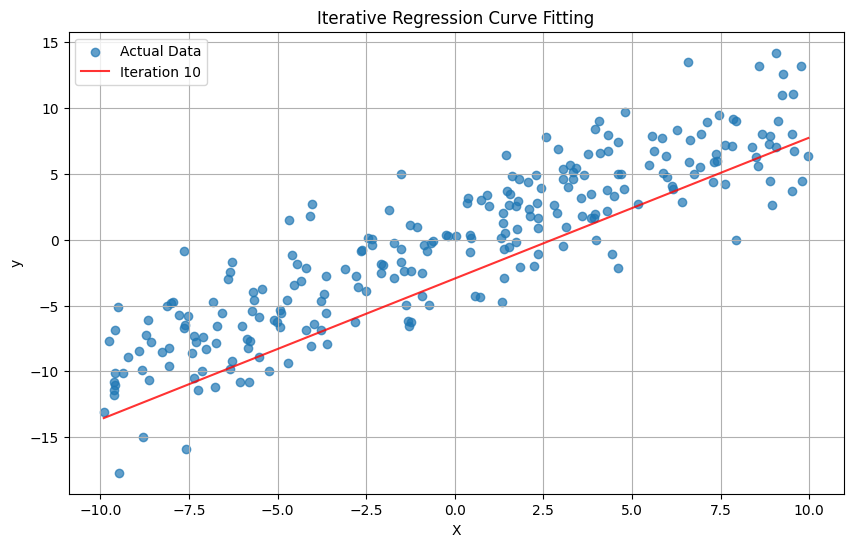

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
sgd_regressor = SGDRegressor(
    max_iter=100,  # Adjust as needed
    learning_rate="constant",
    eta0=0.01,
    random_state=0,
    warm_start=True #Important for iterative visualization
)

train_and_visualize_regression_iteratively(
    sgd_regressor,
    X,
    y,
    n_iterations=10,
    batch_size=32,
    filename_prefix="sgd_regression",
    plot_every=1,
)

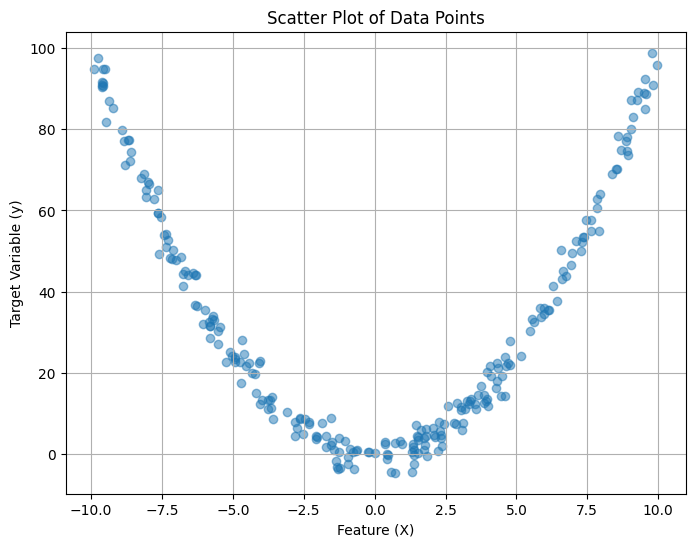

In [ ]:
# Quadratic
X_quad, y_quad = generate_regression_data(n_samples=250, n_features=1, coefficients=[1], intercept=0, noise_std=3, feature_params={'low':-10, 'high':10}, non_linearity=lambda x: x**2)
visualize_data(X_quad, y_quad)

sgd_regressor_quad = SGDRegressor(
    max_iter=100,
    learning_rate="constant",
    eta0=0.01,
    random_state=0,
    warm_start=True
)

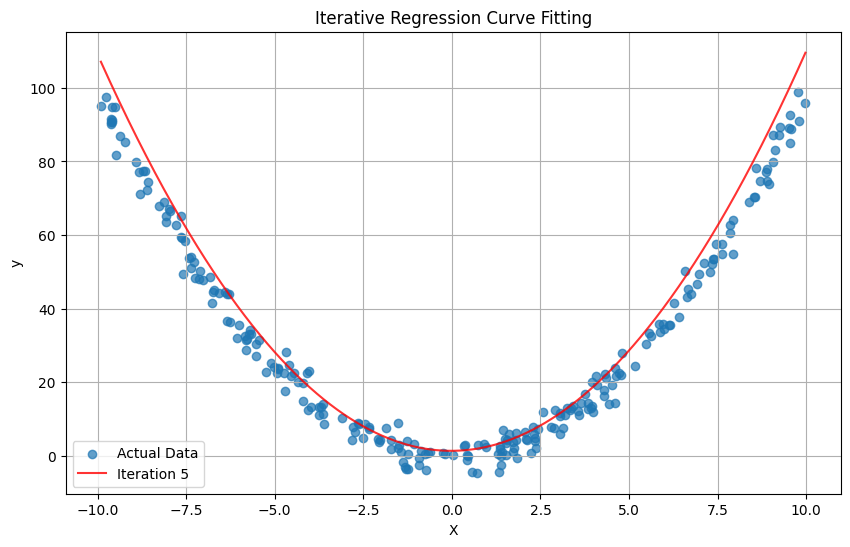

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
train_and_visualize_regression_iteratively(
    sgd_regressor_quad,
    X_quad,
    y_quad,
    n_iterations=5,
    batch_size=32,
    filename_prefix="sgd_regression_quadratic",
    plot_every=1,
    degree = 2 #polynomial degree
)

# Cubic

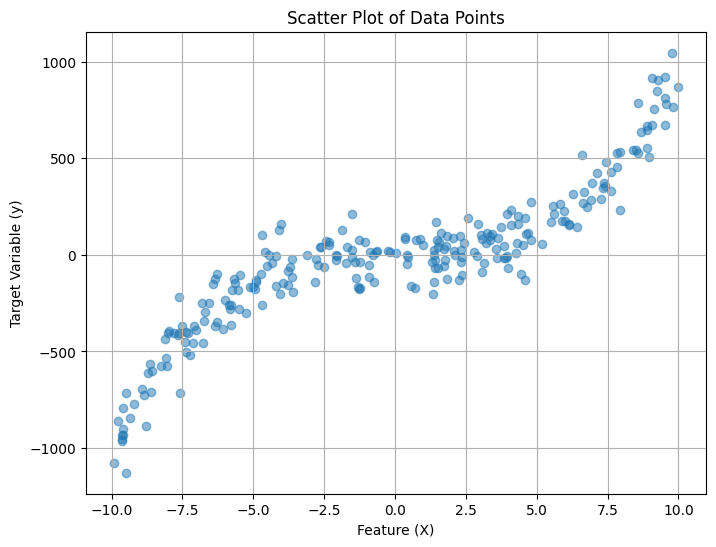

In [ ]:
X_cubic, y_cubic = generate_regression_data(n_samples=250, n_features=1, coefficients=[1], intercept=0, noise_std=100, feature_params={'low':-10, 'high':10}, non_linearity=lambda x: x**3)
visualize_data(X_cubic, y_cubic)

sgd_regressor_cubic = SGDRegressor(
    max_iter=100,
    learning_rate="constant",
    eta0=0.01,
    random_state=0,
    warm_start=True
)


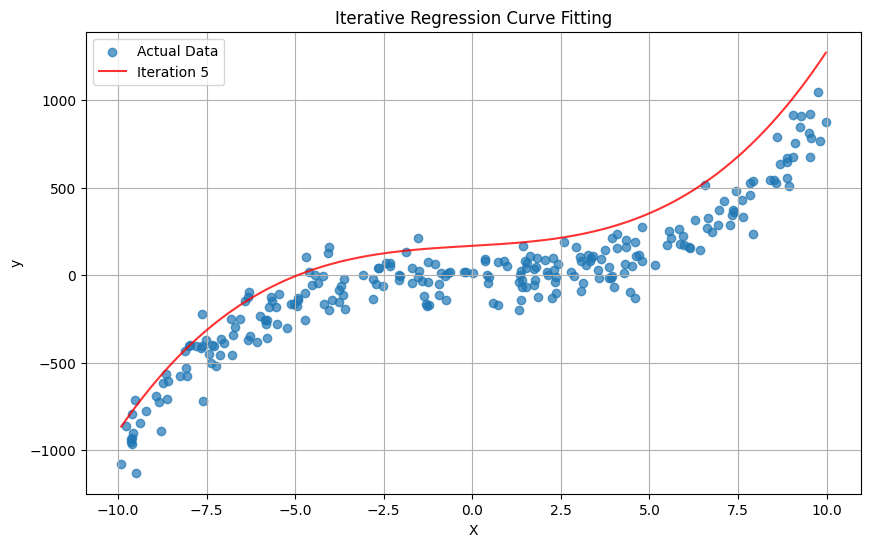

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
train_and_visualize_regression_iteratively(
    sgd_regressor_cubic,
    X_cubic,
    y_cubic,
    n_iterations=5,
    batch_size=32,
    filename_prefix="sgd_regression_cubic",
    plot_every=1,
    degree = 3 #polynomial degree
)

# Sinusoidal

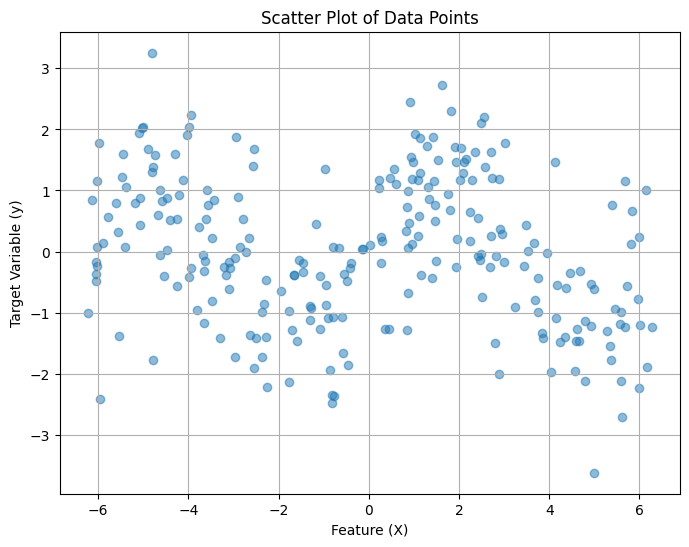

In [ ]:
# Sinusoidal
X_sin, y_sin = generate_regression_data(n_samples=250, n_features=1, coefficients=[1], intercept=0, noise_std=1, feature_params={'low':2*-np.pi, 'high':2*np.pi}, non_linearity=np.sin)
visualize_data(X_sin, y_sin)

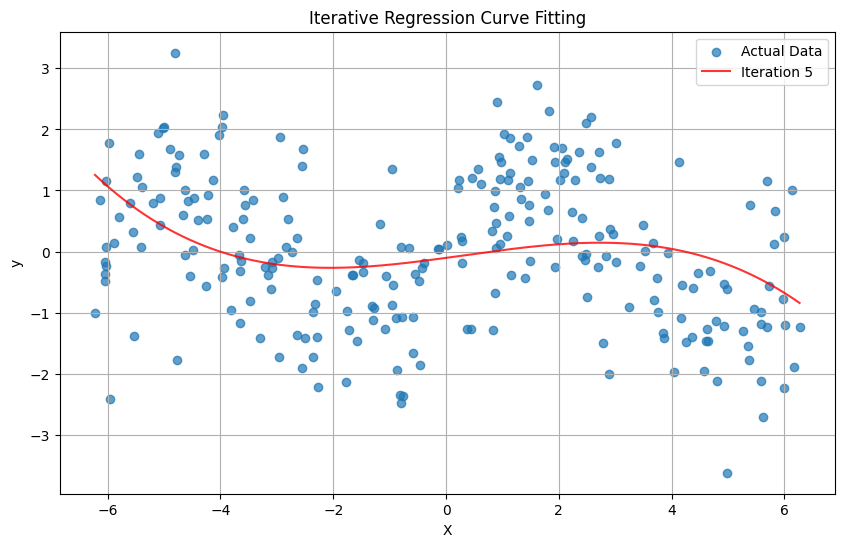

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
sgd_regressor_sin = SGDRegressor(
    max_iter=100,
    learning_rate="constant",
    eta0=0.01,
    random_state=0,
    warm_start=True
)

train_and_visualize_regression_iteratively(
    sgd_regressor_sin,
    X_sin,
    y_sin,
    n_iterations=5,
    batch_size=32,
    filename_prefix="sgd_regression_sinusoidal",
    plot_every=1,
    degree = 4 #polynomial degree
)


# Classification

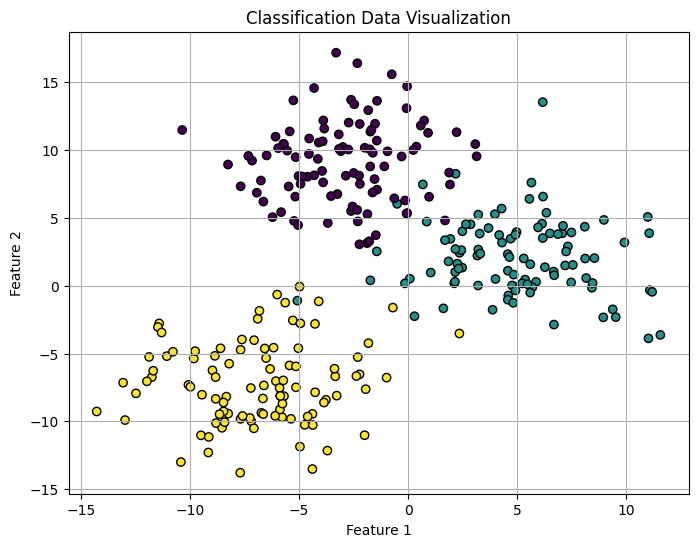

In [ ]:
# Generate 3-class classification data
X_3class, y_3class = generate_classification_data(n_samples=300, n_classes=3, cluster_std=3.0, random_state=42)

# Visualize the data
visualize_classification_data(X_3class, y_3class)

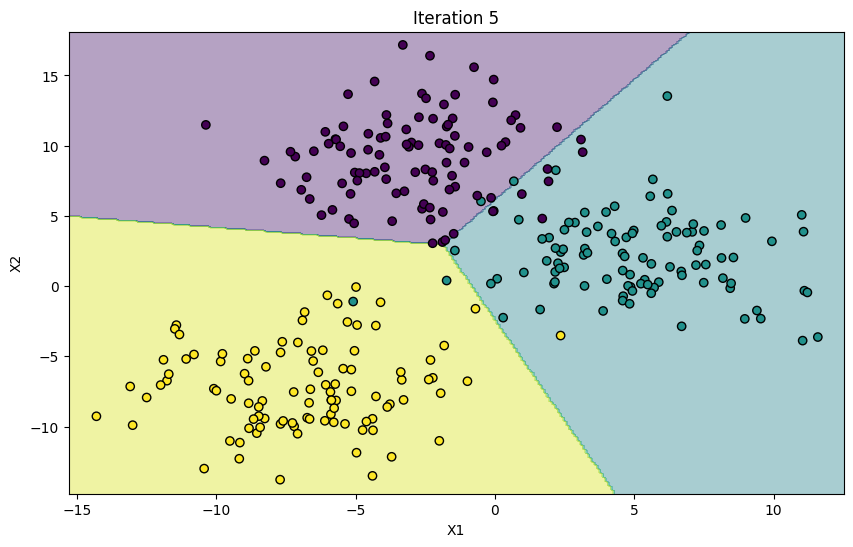

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train and visualize iteratively
sgd_classifier_3class = SGDClassifier(
    max_iter=100,
    loss="log_loss",  # Use logistic regression for classification
    learning_rate="constant",
    eta0=0.01,
    random_state=42,
    warm_start=True
)

train_and_visualize_classification_iteratively(
    sgd_classifier_3class,
    X_3class,
    y_3class,
    n_iterations=5,
    batch_size=32,
    filename_prefix="sgd_classification_3class",
    plot_every=1
)

# Metric

## Regression

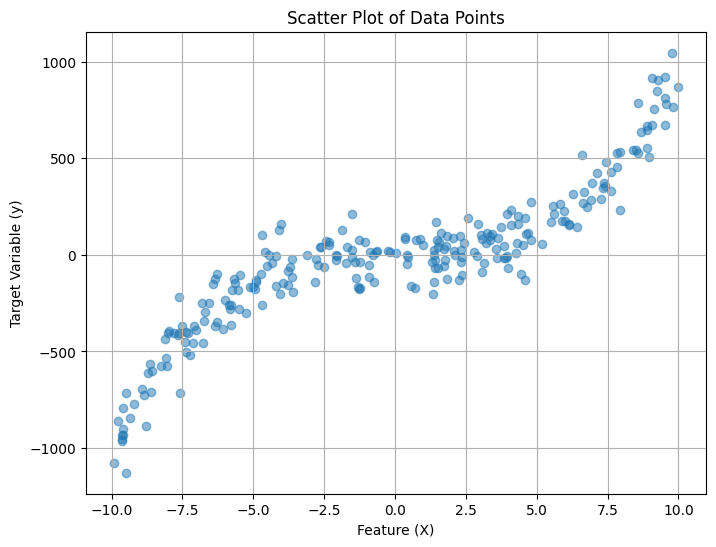

In [ ]:
X_cubic, y_cubic = generate_regression_data(n_samples=250, n_features=1, coefficients=[1], intercept=0, noise_std=100, feature_params={'low':-10, 'high':10}, non_linearity=lambda x: x**3)
visualize_data(X_cubic, y_cubic)

In [ ]:
sgd_regressor_cubic = SGDRegressor(
    max_iter=100,
    learning_rate="constant",
    eta0=0.01,
    random_state=0,
    warm_start=True
)

In [ ]:
# Fit the SGDRegressor
sgd_regressor_cubic.fit(X_cubic, y_cubic)

# Make predictions
y_pred_cubic = sgd_regressor_cubic.predict(X_cubic)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Calculate metrics
mse_cubic = mean_squared_error(y_cubic, y_pred_cubic)
r2_cubic = r2_score(y_cubic, y_pred_cubic)
mae_cubic = mean_absolute_error(y_cubic, y_pred_cubic)

print(f"Mean Squared Error (Cubic): {mse_cubic}")
print(f"Mean Absolute Error (Cubic): {mae_cubic}")
print(f"R-squared (Cubic): {r2_cubic}")

Mean Squared Error (Cubic): 50197.57871843305
Mean Absolute Error (Cubic): 193.73716853063036
R-squared (Cubic): 0.6471171460599188


## Classification

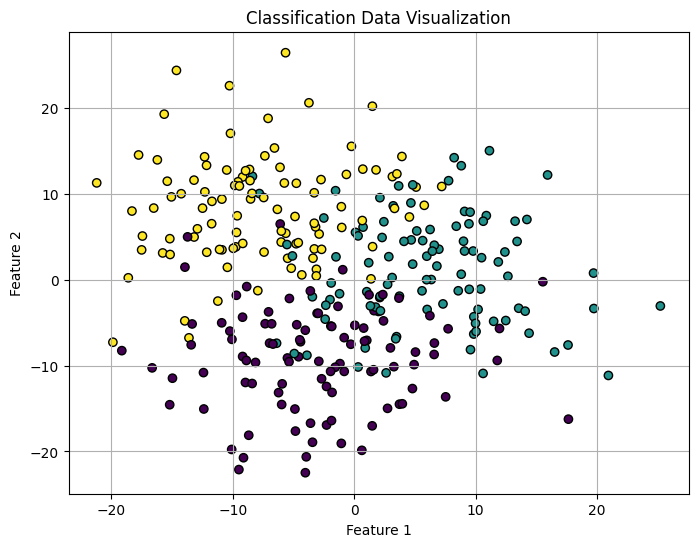

In [ ]:
X_3class, y_3class = generate_classification_data(n_samples=300, n_classes=3, cluster_std=6.0, random_state=737)

# Visualize the data
visualize_classification_data(X_3class, y_3class)

In [ ]:
# Train an SGDClassifier (replace with your actual classifier)
sgd_classifier_3class = SGDClassifier(
    max_iter=100,
    loss="log_loss",  # Example loss function
    learning_rate="constant",
    eta0=0.01,
    random_state=727,
    warm_start=True
)

sgd_classifier_3class.fit(X_3class, y_3class)

# Make predictions
y_pred_3class = sgd_classifier_3class.predict(X_3class)

# Calculate classification metrics
accuracy = accuracy_score(y_3class, y_pred_3class)
precision = precision_score(y_3class, y_pred_3class, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_3class, y_pred_3class, average='weighted')
f1 = f1_score(y_3class, y_pred_3class, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7933333333333333
Precision: 0.7965791546319932
Recall: 0.7933333333333333
F1-score: 0.793550532998162


# Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming sgd_classifier_3class is your classifier and X_3class, y_3class are your data
# Perform 5-fold cross-validation
cv_scores = cross_val_score(sgd_classifier_3class, X_3class, y_3class, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.78333333 0.91666667 0.76666667 0.78333333 0.83333333]
Average Cross-Validation Score: 0.8166666666666667
